# Value Lost
 Demonstration Notebook

A notebook to demonstrate some of the features of the Component class

Author: gavin.treseder@essentialenergy.com.au

In [62]:
#  Add root folder to python path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np 
import pandas as pd
import scipy.stats as ss
from IPython.display import clear_output

import plotly.express as px

from pof import Component

In [49]:
def expected_inspection_interval(x_min, x_max, n_iterations=100):
    rc = dict()
    comp.reset()

    for i in range(max(1, x_min),x_max,1):

        # Set t_interval
        for fm in comp.fm.values():
            if 'inspection' in list(fm.tasks):
                fm.tasks['inspection'].t_interval = i
        
        comp.mc_timeline(t_end=100, n_iterations=n_iterations)

        rc[i] = comp.expected_risk_cost_df().groupby(by=['task'])['cost'].sum()
        rc[i]['inspection_interval'] = i

        # Reset component
        comp.reset()

    df = pd.DataFrame().from_dict(rc, orient='index')
    df['total_cost'] = df.drop(['inspection_interval', 'risk'], axis=1).sum(axis=1)
    df['total'] = df['total_cost'] + df['risk']
    
    return df

In [50]:
df = expected_inspection_interval(0, 10, 10)

100%|██████████| 10/10 [00:00<00:00, 54.94it/s]


## Consider Consequence by Depot

In [48]:
filename = r"C:\Users\gtreseder\OneDrive - KPMG\Documents\3. Client\Essential Energy\Probability of Failure Model\inputs\ACS - Poles - Consequence Model Output.csv"
df_cons = pd.read_csv(filename)


Break the consequenes up into groups so they can be passed into the model

In [22]:
def get_bin_groups(df, bin_on='Total Consequence $', group_by='ASSET_ID', n_bins = 5):

    df['bin_consequence'] = pd.qcut(df['Total Consequence $'], q=3, labels=['low', 'med', 'high'])

    groups = df.groupby(by='bin_consequence').count()

    return df

In [24]:
df_bins = get_bin_groups(df_cons)
df_bins.groupby(by='bin_consequence').count().head()

,Unnamed: 0,ASSET_ID,Depot (ZSG Area),Pole_LU_NSWMajo,Pole_LU_NSWDeta,Pole_LU_ALUMMaj,Pole_LU_ALUMDet,Road Crossing Conductor Type,HV_LV Status,BushfirePriority,...,C_Environment_Rank,Site_Bushfire_Moderate_Probability,Site_Bushfire_Severe_Probability,C_Bushfire_Dollars,Site_Environment_Insignificant_Probability,Site_Environment_Minor_Probability,C_Environment_Dollars,C_Financial_Dollars,Total Consequence $,Radial(Y/N)
bin_consequence,,,,,,,,,,,,,,,,,,,,,
low,459243,459243,459243,444182,444181,444182,444182,398918,398918,459243,...,459243,459243,459243,459243,459243,459243,459243,459243,459243,373
med,459243,459243,459243,457207,457202,457207,457207,436810,436810,459243,...,459243,459243,459243,459243,459243,459243,459243,459243,459243,446
high,459243,459243,459243,454364,454213,454364,454364,436925,436925,459243,...,459243,459243,459243,459243,459243,459243,459243,459243,459243,57316


Consider a depot lense

In [25]:
depots = ['Young Depot', 'Temora Depot', 'Yass Depot', 'Young Depot', 'Bathurst Depot']

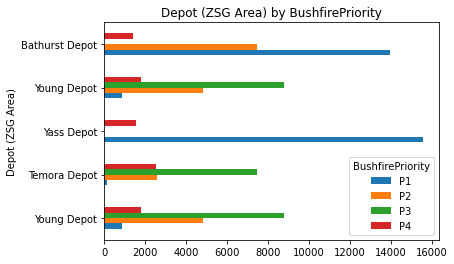

In [31]:
index = 'Depot (ZSG Area)'
columns = 'BushfirePriority'

bushfire = df_bins.pivot_table(index=index, columns= columns, values = 'ASSET_ID', aggfunc=len).fillna(0).astype(int)
bushfire.loc[depots].plot(kind='barh', title=f'{index} by {columns}');

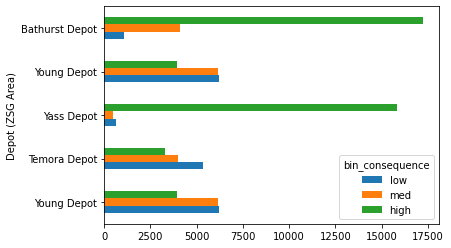

In [29]:
cons = df_bins.pivot_table(index='Depot (ZSG Area)', columns= 'bin_consequence', values = 'ASSET_ID', aggfunc=len).fillna(0).astype(int)
cons.loc[depots].plot(kind='barh');

Using 

In [6]:

def update_inspection_interval_figure():
    
    df = expected_inspection_interval(1,10)
    df_plot = df.melt(id_vars='inspection_interval', var_name = 'source', value_name='cost')
    fig = px.line(df_plot, x="inspection_interval", y="cost", color='source', title='Risk v Cost at different Inspection Intervals')
    return fig

update_inspection_interval_figure().show()

100%|██████████| 100/100 [00:02<00:00, 33.92it/s]


In [64]:
n_iterations = 10
t_min = 1
t_max = 10
scen = dict()

by = 'bin_consequence'
col = 'Total Consequence $'
sens_var = 'inspection_interval'

category_value = df_bins.groupby(by=by)[col].mean()


for category, value in zip(category_value.index, category_value.to_numpy().astype(int)):
    comp = Component.demo()

    # Update consequence for all the failure modes
    for fm in comp.fm.values():
        fm.consequence.risk_cost_total = 12000

    scen[category] = expected_inspection_interval(t_min, t_max, n_iterations)

df_all = pd.concat(scen).reset_index()
df_all = df_all.rename(columns = {'level_0':by, 'level_1':sens_var})

clear_output(True)
df_all.head()

,bin_consequence,inspection_interval,inspection,on_condition_repair,on_condition_replacement,on_failure_replacement,risk,inspection_interval,total_cost,total
0,low,1,8320,130,0,3000,3600,1,11450,15050
1,low,2,6742,180,0,1000,1200,2,7922,9122
2,low,3,5360,180,0,0,0,3,5540,5540
3,low,4,4014,180,0,1000,1200,4,5194,6394
4,low,5,2730,110,0,3000,3600,5,5840,9440


In [70]:
#TODO will need to get total time from components
df_all['annual_value_lost'] = (df_all['total'] - df_all.groupby(by =by)['total'].transform('min'))/100 # time considered

df_plot = df_all#df_all.melt(id_vars='inspection_interval', var_name = 'source', value_name='cost')
fig = px.line(df_plot, x=by, y="annual_value_lost", color=col, title='Risk v Cost at different Inspection Intervals', color_discrete_sequence=px.colors.qualitative.Vivid)
fig.show()

ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['bin_consequence', 'inspection_interval', 'inspection', 'on_condition_repair', 'on_condition_replacement', 'on_failure_replacement', 'risk', 'inspection_interval', 'total_cost', 'total', 'annual_value_lost'] but received: Total Consequence $

<AxesSubplot:ylabel='Depot (ZSG Area)'>

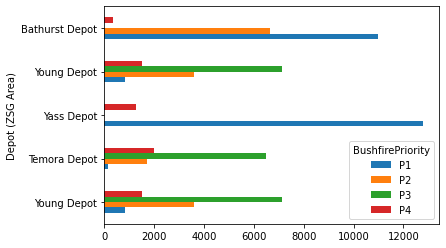

In [192]:
bushfire.loc[(bushfire != 0).all(axis=1)]

BushfirePriority,P1,P2,P3,P4
Depot (ZSG Area),,,,
Bulahdelah Depot,135,2404,4531,981
Griffith Depot,327,10682,2286,4387
Temora Depot,136,1719,6500,1989
Young Depot,816,3597,7123,1533
[ Deleted Assets ],22,266,83,39


In [193]:
bushfire = bushfire.reset_index().melt(id_vars='Depot (ZSG Area)', value_name='population')
bushfire.head()

,Depot (ZSG Area),BushfirePriority,population
0,Albury Depot,P1,2065
1,Armidale Depot,P1,0
2,Ballina Depot,P1,0
3,Balranald Depot,P1,0
4,Barham Depot,P1,0


In [194]:
df_bushfire = df_all.loc[df_all['scenario'].isin(['high_c', 'low_c']), ['scenario', 'inspection_interval', 'value_lost']]

In [195]:
df_bushfire['key'] = 0
bushfire['key'] = 0

jt = bushfire.merge(df_bushfire, on='key', how='outer')
jt.head()

,Depot (ZSG Area),BushfirePriority,population,key,scenario,inspection_interval,value_lost
0,Albury Depot,P1,2065,0,high_c,1,71.35
1,Albury Depot,P1,2065,0,high_c,2,0.00
2,Albury Depot,P1,2065,0,high_c,3,10.59
3,Albury Depot,P1,2065,0,high_c,4,79.56
4,Albury Depot,P1,2065,0,high_c,5,265.90


In [196]:
jt['total_value_lost'] = (jt.population * jt.value_lost).where((jt.BushfirePriority == 'P1') & (jt.scenario == 'high_c')).fillna(0)
jt['total_value_lost'] = jt['total_value_lost'] + (jt.population * jt.value_lost).where((jt.BushfirePriority != 'P1') & (jt.scenario == 'low_c')).fillna(0)
jt.head()

,Depot (ZSG Area),BushfirePriority,population,key,scenario,inspection_interval,value_lost,total_value_lost
0,Albury Depot,P1,2065,0,high_c,1,71.35,147337.75
1,Albury Depot,P1,2065,0,high_c,2,0.00,0.00
2,Albury Depot,P1,2065,0,high_c,3,10.59,21868.35
3,Albury Depot,P1,2065,0,high_c,4,79.56,164291.40
4,Albury Depot,P1,2065,0,high_c,5,265.90,549083.50


In [197]:
rh = jt.groupby(by=['Depot (ZSG Area)', 'inspection_interval'])['total_value_lost'].sum().reset_index()

In [198]:
rh = rh.loc[rh['Depot (ZSG Area)'].isin(depots)]

fig = px.line(
    rh,
    x="inspection_interval",
    y="total_value_lost",
    color="Depot (ZSG Area)",
    title= 'Optimum Inspection Interval by Depot'
)
fig

In [199]:
rh.groupby(by=['Depot (ZSG Area)']).min()

,inspection_interval,total_value_lost
Depot (ZSG Area),,
Bathurst Depot,1,129291.74
Temora Depot,1,10820.16
Yass Depot,1,29534.58
Young Depot,1,31309.49


In [51]:
fig = px.area(
    df,
    x="time",
    y="cost_cumulative",
    color="task",
    line_group = 'failure_mode'
)
fig

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['immediate_replacement', 'inspection', 'on_condition_repair', 'on_condition_replacement', 'risk', 'inspection_interval', 'total_cost', 'total'] but received: time

101

In [112]:
comp.mc_timeline(200, n_iterations=1000)

100%|██████████| 1000/1000 [00:25<00:00, 39.15it/s]


In [113]:

import plotly.graph_objects as go


def update_condition_fig(*args):
    """ Updates the condition figure"""

    fig = go.Figure()

    ecl = comp.expected_condition_loss()

    cmap = px.colors.qualitative.Safe
    ci = 0

    for cond_name, cond in ecl.items():
        # Format the data for plotting
        length = len(cond['mean'])
        time = np.linspace(0,length  -1, length, dtype=int) # TODO take time as a variable
        x = np.append(time,time[::-1])
        y = np.append(cond['upper'], cond['lower'][::-1])

        # Add the boundary
        fig.add_trace(go.Scatter(
            x=x,
            y=y,
            fill='toself',
            fillcolor='rgba' + cmap[ci][3:-2] + ',0.2)',
            line_color='rgba(255,255,255,0)',
            showlegend=False,
            name=cond_name,
        ))
        fig.add_trace(go.Scatter(
            x=time, y=cond['mean'],
            line_color=cmap[ci],
            name=cond_name,
        ))

        ci = ci + 1

        fig.update_traces(mode='lines')
        fig.update_xaxes(title_text='Time')
        fig.update_yaxes(title_text='Condition (%)')

    return fig


fig = update_condition_fig()
fig.show()

In [11]:
fm = comp.fm['random']
stdev = 1

expected = dict()
for cond_name, condition in fm.conditions.items():

    ec = np.array([fm._timelines[x][cond_name] for x in fm._timelines])

    mean = condition.perfect - ec.mean(axis=0)
    sd = ec.std(axis=0)
    upper = mean + sd*stdev
    lower = mean - sd*stdev

    upper[upper > condition.perfect] = condition.perfect
    lower[lower < condition.failed] = condition.failed

    expected[cond_name] = dict(
        lower=lower,
        mean=mean,
        upper=upper,
        sd=sd,
            )

TypeError: 'numpy.float64' object does not support item assignment

In [18]:
fm.timeline

{}

In [13]:
n_time = 1001
time = list(np.linspace(0,n_time - 1, n_time))

failure_modes = []
tasks = []
times = []
costs = []
cumulative_costs = []

n_fm = len(erc)

for fm, fm_values in erc.items():

    for task, task_values in fm_values.items():
        failure_mode = np.full(n_time, fm)
        task = np.full(n_time, task)
        cost = np.full(n_time, 0)
        cost[task_values['time']] = task_values['cost']
        cumulative_cost = cost.cumsum()

        failure_modes = np.append(failure_modes, failure_mode)
        tasks = np.append(tasks, task)
        costs = np.append(costs, cost)
        times = np.append(times, time)
        cumulative_costs = np.append(cumulative_costs, cumulative_cost)


df = pd.DataFrame(
    dict(
        failure_mode=failure_modes,
        task=tasks,
        time=times,
        cost=costs,
        cumulative_cost=cumulative_costs,
    )
)

IndexError: arrays used as indices must be of integer (or boolean) type

In [14]:
times = np.linspace(0,100,101, dtype=int)
n=101

time = np.array(df['time'].values.tolist())
cost = np.array(df['cost'].values.tolist())
fmt = np.repeat(df[['failure_mode', 'task']].to_numpy(),n, axis=0)
pd.DataFrame(np.column_stack((a, vals.ravel())), columns=df.columns)

NameError: name 'a' is not defined

In [15]:
profile = comp.fm['random'].expected_cost()
profile['risk'] = comp.fm['random'].expected_risk()

AttributeError: 'FailureMode' object has no attribute 'expected_cost'

In [16]:
%timeit comp.fm['slow_aging'].expected_cost_df()

27.6 ms ± 9.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%timeit comp.fm['slow_aging'].expected_risk_cost_df()

3.79 ms ± 535 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
rc = comp.fm['slow_aging'].expected_risk_cost()

In [19]:
new_index = pd.Index(np.arange(0, 200, 1), name="time")

t = rc['inspection']['time']
c = rc['inspection']['cost']

In [20]:
tc = dict(task=[], time=[], cost=[])

for k, v in rc.items():
    tc['task'] = np.append(tc['task'], np.full(len(v['time']), k))
    for m in ['time', 'cost']:
        time = tc[m]
        
        

        tc[m] = np.append(tc[m], v[m])

array([ 0. , 50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. ,
       50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. ,
       50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. , 50. ,
       50. , 50. , 50. , 50. , 50. , 50. , 50. , 49.5])

In [21]:
df = comp.fm['random'].expected_risk_cost_df()
df.index.name = 'task'
df = df.reset_index()

In [22]:
df = comp.fm['slow_aging'].expected_risk_cost_df()

In [23]:

px.line(
    df.reset_index(),
    x="time",
    y="cumulative_cost",
    color="task",
    line_group =
)

SyntaxError: invalid syntax (<ipython-input-23-cdf092dcd93a>, line 7)

In [6]:
comp = Component().demo()
comp.fm

{}

In [16]:
df = comp.sensitivity("comp-fm-early_life-dists-untreated-alpha", 0, 5)

100%|██████████| 10/10 [00:00<00:00, 75.19it/s]


In [17]:
df

,risk_cost,alpha,direct_cost,total
1,55000,1,80500,135500
2,30000,2,29445,59445
3,19997,3,17108,37105
4,15000,4,11305,26305


In [18]:
df = comp.sensitivity("comp-fm-early_life-tasks-inspection-cost", 50, 55)

100%|██████████| 10/10 [00:00<00:00, 73.57it/s]


In [19]:
df

,risk_cost,cost,direct_cost,total
50,10000,50,9698,19698
51,9164,51,9629,18793
52,9282,52,6421,15703
53,6875,53,4930,11805
54,7217,54,5482,12699


In [5]:
import plotly.graph_objects as go

def make_sensitivity_fig(local, var_name = "comp-fm-early_life-tasks-inspection-cost", lower=0, upper=10, step=1, n_iterations=10):
    
    var = var_name.split("-")[-1]

    try:
        df = local.sensitivity(var_name = var_name, lower=lower, upper=upper, step=step, n_iterations=n_iterations
        )
        df_plot = df.melt(id_vars=var, var_name="source", value_name="Cost")
        fig = px.line(
            df_plot,
            x=var,
            y="Cost",
            color="source",
            title="Risk v Cost at different " + var,
        )
    except:
        fig = go.Figure(
            layout=go.Layout(
                title=go.layout.Title(text="Error Producing " + var)
            )
        )

    return fig

In [8]:
var_name = "comp-fm-early_life-tasks-inspection-cost"
var = var_name.split("-")[-1]

df = comp.sensitivity(var_name = var_name, lower=0, upper=1000, step=100, n_iterations=100)

100%|██████████| 100/100 [00:01<00:00, 72.51it/s]


In [3]:
comp.fm.pop('fast_aging')
comp.fm.pop('slow_aging')
comp.fm.pop('random')
comp.fm

{'early_life': <pof.failure_mode.FailureMode at 0x5afe5f8>}

In [10]:
#only early_life
fig = make_sensitivity_fig(comp, var_name = "comp-fm-early_life-tasks-inspection-cost", lower=0, upper=1000, step=100, n_iterations=100)
fig.show()

100%|██████████| 100/100 [00:01<00:00, 85.05it/s]


In [4]:
comp.fm.pop('slow_aging')
comp.fm.pop('random')
comp.fm

{'early_life': <pof.failure_mode.FailureMode at 0x52ee688>,
 'fast_aging': <pof.failure_mode.FailureMode at 0x1b915bc8>}

In [5]:
#early_life + fast_aging
fig = make_sensitivity_fig(comp, var_name = "comp-fm-early_life-tasks-inspection-cost", lower=0, upper=1000, step=100, n_iterations=100)
fig.show()

100%|██████████| 100/100 [00:00<00:00, 134.59it/s]


In [2]:
comp = Component().demo()
comp.fm

{'early_life': <pof.failure_mode.FailureMode at 0x1b923538>,
 'random': <pof.failure_mode.FailureMode at 0x1b923658>,
 'slow_aging': <pof.failure_mode.FailureMode at 0x1b9237d8>,
 'fast_aging': <pof.failure_mode.FailureMode at 0x1b9239a0>}

In [3]:
comp.fm.pop('random')
comp.fm

{'early_life': <pof.failure_mode.FailureMode at 0x624e1d8>,
 'slow_aging': <pof.failure_mode.FailureMode at 0x1c42b100>,
 'fast_aging': <pof.failure_mode.FailureMode at 0x1ccd5bb0>}

In [6]:
#early_life + fast_aging + slow_aging
fig = make_sensitivity_fig(comp, var_name = "comp-fm-early_life-tasks-inspection-cost", lower=0, upper=1000, step=100, n_iterations=100)
fig.show()

100%|██████████| 100/100 [00:00<00:00, 107.64it/s]


In [3]:
comp.fm.pop('early_life')
comp.fm.pop('slow_aging')
comp.fm.pop('random')
comp.fm

{'fast_aging': <pof.failure_mode.FailureMode at 0x1bfa5be0>}

In [13]:
#fast_aging
fig = make_sensitivity_fig(comp, var_name = "comp-fm-fast_aging-tasks-inspection-cost", lower=0, upper=1000, step=100, n_iterations=100)
fig.show()

100%|██████████| 100/100 [00:00<00:00, 195.31it/s]


In [6]:
fig = make_sensitivity_fig(comp, var_name = "comp-fm-fast_aging-dists-untreated-alpha", lower=0, upper=10, step=1, n_iterations=100)
fig.show()

100%|██████████| 100/100 [00:00<00:00, 109.65it/s]


In [5]:
comp.fm["fast_aging"].tasks["inspection"].cost = 0
comp.fm["fast_aging"].tasks["inspection"].cost

0

In [6]:
comp.mc_timeline(100)

100%|██████████| 100/100 [00:00<00:00, 150.60it/s]


In [7]:
comp.expected_risk_cost()

{'fast_aging': {'inspection': {'time': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
           70,  75,  80,  85,  90,  95, 100]),
   'cost': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.])},
  'on_condition_repair': {'time': array([32, 37, 38, 43, 46, 48, 51, 52, 53, 54, 56, 57, 61, 62, 63, 66, 67,
          68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 81, 82, 83, 86, 87, 88, 91,
          92, 93, 94, 95, 96, 97, 98]),
   'cost': array([1., 1., 2., 2., 3., 1., 2., 2., 1., 1., 2., 3., 3., 2., 1., 3., 3.,
          1., 1., 5., 1., 1., 1., 1., 1., 3., 1., 5., 1., 1., 4., 3., 1., 3.,
          3., 2., 1., 1., 4., 2., 1.])},
  'on_condition_replacement': {'time': array([], dtype=float64),
   'cost': array([], dtype=float64)},
  'risk': {'time': array([61, 81], dtype=int32), 'cost': array([500., 500.])}}}

In [8]:
comp.fm["fast_aging"].tasks["inspection"].cost = 1000
comp.fm["fast_aging"].tasks["inspection"].cost

1000

In [9]:
comp.mc_timeline(100)

100%|██████████| 100/100 [00:00<00:00, 156.74it/s]


In [10]:
comp.expected_risk_cost()

{'fast_aging': {'inspection': {'time': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
           70,  75,  80,  85,  90,  95, 100]),
   'cost': array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
          1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
          1000., 1000.])},
  'on_condition_repair': {'time': array([31, 32, 38, 46, 51, 52, 53, 56, 57, 58, 61, 62, 63, 64, 65, 66, 67,
          71, 72, 73, 76, 78, 79, 81, 82, 83, 84, 86, 87, 88, 89, 91, 92, 93,
          96, 97, 98]),
   'cost': array([1., 1., 1., 1., 3., 1., 1., 1., 1., 1., 5., 2., 2., 1., 1., 3., 1.,
          3., 4., 1., 5., 1., 1., 7., 3., 1., 1., 8., 4., 3., 1., 4., 3., 1.,
          5., 2., 2.])},
  'on_condition_replacement': {'time': array([], dtype=float64),
   'cost': array([], dtype=float64)},
  'risk': {'time': array([ 66,  68,  70,  98, 100], dtype=int32),
   'cost': array([500., 500., 500., 500., 500.])}}}

In [11]:
comp.fm["fast_aging"].timeline = {}
comp.fm["fast_aging"]._timelines = {}
comp.fm["fast_aging"].__dict__

{'_name': 'fast_aging',
 'active': True,
 '_pf_curve': 'linear',
 '_pf_interval': 10,
 'pf_std': 0,
 'dists': {'untreated': Distribution(name='untreated', alpha=100, beta=3.5, gamma=10),
  'init': Distribution(name='dist', alpha=100, beta=3.5, gamma=0)},
 'indicators': {'slow_degrading': ConditionIndicator(name='slow_degrading', pf_curve='linear', pf_interval=20, pf_std=0.5, perfect=100, failed=0, decreasing=True, threshold_detection=100, threshold_failure=0),
  'fast_degrading': ConditionIndicator(name='fast_degrading', pf_curve='linear', pf_interval=10, pf_std=0.5, perfect=100, failed=0, decreasing=True, threshold_detection=100, threshold_failure=0)},
 'conditions': {'slow_degrading': {'name': 'slow_degrading',
   'perfect': 100,
   'failed': 0,
   'pf_curve': 'linear',
   'pf_interval': 20,
   'pf_std': 0.5},
  'fast_degrading': {'name': 'fast_degrading',
   'perfect': 100,
   'failed': 0,
   'pf_curve': 'linear',
   'pf_interval': 10,
   'pf_std': 0.5}},
 'consequences': {},
 'cons

In [6]:
df = comp.sensitivity("comp-fm-early_life-tasks-inspection-cost", 50, 55)

100%|██████████| 10/10 [00:00<00:00, 71.93it/s]


In [37]:
from pof.failure_mode import FailureMode
import pof.demo as demo

fm = FailureMode.from_dict(demo.failure_mode_data["random"])
fm.name = "fm"

In [26]:
df = fm.sensitivity("fm-dists-untreated-alpha", 0, 5)

100%|██████████| 10/10 [00:00<00:00, 138.90it/s]


In [4]:
df

,alpha,direct_cost,risk_cost,total
1,1,1600,5000,6600
2,2,540,0,540
3,3,526,1666,2192
4,4,510,2500,3010


In [40]:
fig = make_sensitivity_fig(var_name = "fm-tasks-inspection-cost", lower=0, upper=1000, step=100, n_iterations=20)
fig.show()

100%|██████████| 20/20 [00:00<00:00, 188.67it/s]


In [38]:
import plotly.graph_objects as go

def make_sensitivity_fig(var_name = "comp-fm-early_life-tasks-inspection-cost", lower=0, upper=10, step=1, n_iterations=10):
    
    var = var_name.split("-")[-1]

    try:
        df = fm.sensitivity(var_name = var_name, lower=lower, upper=upper, step=step, n_iterations=n_iterations
        )
        df_plot = df.melt(id_vars=var, var_name="source", value_name="Cost")
        fig = px.line(
            df_plot,
            x=var,
            y="Cost",
            color="source",
            title="Risk v Cost at different " + var,
        )
    except:
        fig = go.Figure(
            layout=go.Layout(
                title=go.layout.Title(text="Error Producing " + var)
            )
        )

    return fig

In [7]:
failure_mode_data = dict(
        name='early_life',
        pf_curve = 'linear',
        pf_interval=10)

In [10]:
for var, val in failure_mode_data.items():
    d = {}
    d[var] = val
    print(d)

{'name': 'early_life'}
{'pf_curve': 'linear'}
{'pf_interval': 10}


In [3]:
comp.get_dash_ids()

['comp-active',
 'comp-fm-early_life-active',
 'comp-fm-early_life-pf_curve',
 'comp-fm-early_life-pf_interval',
 'comp-fm-early_life-pf_std',
 'comp-fm-early_life-dists-untreated-alpha',
 'comp-fm-early_life-dists-untreated-beta',
 'comp-fm-early_life-dists-untreated-gamma',
 'comp-fm-early_life-tasks-inspection-active',
 'comp-fm-early_life-tasks-inspection-p_effective',
 'comp-fm-early_life-tasks-inspection-cost',
 'comp-fm-early_life-tasks-inspection-t_interval',
 'comp-fm-early_life-tasks-inspection-t_delay',
 'comp-fm-early_life-tasks-inspection-trigger-condition-instant-lower',
 'comp-fm-early_life-tasks-inspection-trigger-condition-instant-upper',
 'comp-fm-early_life-tasks-inspection-trigger-state-initiation',
 'comp-fm-early_life-tasks-inspection-impact-state-detection',
 'comp-fm-early_life-tasks-on_condition_replacement-active',
 'comp-fm-early_life-tasks-on_condition_replacement-p_effective',
 'comp-fm-early_life-tasks-on_condition_replacement-cost',
 'comp-fm-early_life-t

In [3]:
def component_val_to_csv():
    comp = Component().demo()

    
    d = {}
    d_split = {}
    for id_ in comp.get_dash_ids():
        
        id_str = id_.split("comp" + "-", 1)[1]
        id_str = id_str.split("-")

        value = comp

        for s in id_str:
            if s == "fm":
                value = value.fm
            elif s == "active":
                value = value.active
            elif s == "pf_curve":
                value = value.pf_curve
            elif s == "pf_interval":
                value = value.pf_interval
            elif s == "pf_std":
                value = value.pf_std
            elif s == "dists":
                value = value.dists
            elif s == "alpha":
                value = value.alpha
            elif s == "beta":
                value = value.beta
            elif s == "gamma":
                value = value.gamma
            elif s == "tasks":
                value = value.tasks
            elif s == "p_effective":
                value = value.p_effective
            elif s == "cost":
                value = value.cost
            elif s == "t_interval":
                value = value.t_interval
            elif s == "t_delay":
                value = value.t_delay
            elif s == "states":
                value = value.states
            elif s == "impact":
                value = value.impacts
            elif s == "trigger":
                value = value.triggers
            elif s == id_str[-1]:
                # if isinstance(value[s], str):
                #     continue
                # elif isinstance(value[s], bool):
                #     continue
                # else:
                #     d[id_] = value[s]
                #     d_split[id_] = id_.split("-")
                d[id_] = value[s]
                d_split[id_] = id_.split("-")
            else:
                value = value[s]
    df = pd.DataFrame(d.items(), columns=['name', 'mean'])
    test = pd.DataFrame(d_split.items())
    df[["key_1", "key_2", "key_3", "key_4", "key_5", "key_6", "key_7", "key_8", "key_9"]] = pd.DataFrame(test[1].to_list())
    df.set_index(["name"], drop = True).to_csv("csv.csv")


In [12]:
# import pof.test.fixtures
# comp = Component.from_dict(fixtures.component_data_slow["comp"])

comp = Component().demo()
# comp.fm.pop('fast_aging')
# comp.fm.pop('early_life')
# comp.fm.pop('random')

d = {}
d_split = {}
for id_ in comp.get_dash_ids():
    
    id_str = id_.split("comp" + "-", 1)[1]
    id_str = id_str.split("-")

    value = comp

    for s in id_str:
        if s == "fm":
            value = value.fm
        elif s == "active":
            value = value.active
            if isinstance(value, str):
                continue
            elif isinstance(value, bool):
                continue
            else:
                d[id_] = value
                d_split[id_] = id_.split("-")
        elif s == "pf_curve":
            value = value.pf_curve
            if isinstance(value, str):
                continue
            elif isinstance(value, bool):
                continue
            else:
                d[id_] = value
                d_split[id_] = id_.split("-")
        elif s == "pf_interval":
            value = value.pf_interval
            if isinstance(value, str):
                continue
            elif isinstance(value, bool):
                continue
            else:
                d[id_] = value
                d_split[id_] = id_.split("-")
        elif s == "pf_std":
            value = value.pf_std
            if isinstance(value, str):
                continue
            elif isinstance(value, bool):
                continue
            else:
                d[id_] = value
                d_split[id_] = id_.split("-")
        elif s == "dists":
            value = value.dists
        elif s == "alpha":
            value = value.alpha
            if isinstance(value, str):
                continue
            elif isinstance(value, bool):
                continue
            else:
                d[id_] = value
                d_split[id_] = id_.split("-")
        elif s == "beta":
            value = value.beta
            if isinstance(value, str):
                continue
            elif isinstance(value, bool):
                continue
            else:
                d[id_] = value
                d_split[id_] = id_.split("-")
        elif s == "gamma":
            value = value.gamma
            if isinstance(value, str):
                continue
            elif isinstance(value, bool):
                continue
            else:
                d[id_] = value
                d_split[id_] = id_.split("-")
        elif s == "tasks":
            value = value.tasks
        elif s == "p_effective":
            value = value.p_effective
            if isinstance(value, str):
                continue
            elif isinstance(value, bool):
                continue
            else:
                d[id_] = value
                d_split[id_] = id_.split("-")
        elif s == "cost":
            value = value.cost
            if isinstance(value, str):
                continue
            elif isinstance(value, bool):
                continue
            else:
                d[id_] = value
                d_split[id_] = id_.split("-")
        elif s == "t_interval":
            value = value.t_interval
            if isinstance(value, str):
                continue
            elif isinstance(value, bool):
                continue
            else:
                d[id_] = value
                d_split[id_] = id_.split("-")
        elif s == "t_delay":
            value = value.t_delay
            if isinstance(value, str):
                continue
            elif isinstance(value, bool):
                continue
            else:
                d[id_] = value
                d_split[id_] = id_.split("-")
        elif s == "states":
            value = value.states
        elif s == "impact":
            value = value.impacts
        elif s == "trigger":
            value = value.triggers
        elif s == id_str[-1]:
            if isinstance(value[s], str):
                continue
            elif isinstance(value[s], bool):
                continue
            if isinstance(value[s], list):
                continue
            else:
                d[id_] = value[s]
                d_split[id_] = id_.split("-")
        else:
            value = value[s]
df = pd.DataFrame(d.items(), columns=['name', 'mean'])
df["sd"] = df['mean']*.2
df


,name,mean,sd
0,comp-fm-early_life-pf_interval,10.0,2.0
1,comp-fm-early_life-pf_std,0.0,0.0
2,comp-fm-early_life-dists-untreated-alpha,1000000.0,200000.0
3,comp-fm-early_life-dists-untreated-beta,0.5,0.1
4,comp-fm-early_life-dists-untreated-gamma,0.0,0.0
...,...,...,...
79,comp-fm-fast_aging-tasks-on_condition_replacem...,0.0,0.0
80,comp-fm-fast_aging-tasks-on_condition_replacem...,20.0,4.0
81,comp-fm-fast_aging-tasks-on_condition_replacem...,0.0,0.0
82,comp-fm-fast_aging-tasks-on_condition_replacem...,20.0,4.0


In [3]:
df_inspection_slow = df[df['name'].str.contains('cost')]
df_inspection_slow = df_inspection_slow[df_inspection_slow['name'].str.contains('slow')]
df_inspection_slow

,name,mean,sd
38,comp-fm-slow_aging-tasks-inspection-cost,55,5
47,comp-fm-slow_aging-tasks-on_condition_repair-cost,100,5
56,comp-fm-slow_aging-tasks-on_condition_replacem...,5000,5


In [4]:
df_inspection_slow['sd'] = df_inspection_slow['mean']*.2
df_inspection_slow

,name,mean,sd
38,comp-fm-slow_aging-tasks-inspection-cost,55,11
47,comp-fm-slow_aging-tasks-on_condition_repair-cost,100,20
56,comp-fm-slow_aging-tasks-on_condition_replacem...,5000,1000


In [5]:
conf = 0.9
n_increments = 10
n_iterations = 100
#if it's even add one

df_sens = comp.sensitivity(var_name = df_inspection_slow, conf =  conf, n_increments = n_increments, n_iterations = n_iterations)

comp.make_sensitivity_plot(data = df_sens, x_axis = 'conf', y_axis = 'var_name', failure_mode = 'slow_aging', plot_type = 'heatmap', z_axis = 'risk_cost')


100%|██████████| 100/100 [00:03<00:00, 31.13it/s]


In [8]:
df_plot = df_section.groupby(by = ['var_name']).min()
df_plot

,value,direct_cost,risk_cost,total,percent_change,conf
var_name,,,,,,
comp-fm-slow_aging-tasks-inspection-cost,36.906610,0.909091,0.880952,0.882995,0.671029,0.05
comp-fm-slow_aging-tasks-on_condition_repair-cost,67.102927,0.869565,0.774194,0.775930,0.671029,0.05
comp-fm-slow_aging-tasks-on_condition_replacement-cost,3355.146373,0.833333,0.938596,0.937285,0.671029,0.05


In [9]:
fig = px.bar(df_plot.reset_index(), x='risk_cost', y='var_name', color = 'var_name', width=1000, height=500)
fig.layout.update(showlegend=False, title = 'Cost affect on Risk Cost')
fig.show()